# I’m Something of a Painter Myself
## Use GANs to create art - will you be the next Monet?

https://www.kaggle.com/competitions/gan-getting-started

### The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### Ressources:
- https://arxiv.org/pdf/1703.10593.pdf
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
- https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings
- https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings
- https://www.kaggle.com/code/unfriendlyai/diffaugment-is-all-you-need
- https://github.com/mit-han-lab/data-efficient-gans

## Imports

In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Layer

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2022-06-01 10:54:32.263992: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-01 10:54:32.264100: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Connecting to TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-06-01 10:54:37.140678: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-01 10:54:37.144667: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-01 10:54:37.144698: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 10:54:37.144724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e99023a416f): /proc/driver/nvidia/version does not exist
2022-06-01 10:54:37.147863: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


## Loading and Preprocessing Data

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()
EPOCHS = 100
SIZE = 256
SIZE_RESIZE = 128
BATCH_SIZE = 16

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-06-01 10:54:43.720540: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-01 10:54:43.816853: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[SIZE_RESIZE, SIZE_RESIZE, 3])

    return cropped_image

In [6]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    image = tf.image.random_crop(image, size=[SIZE_RESIZE, SIZE_RESIZE, 3])
        
    return image

In [7]:
IMAGE_SIZE = [SIZE, SIZE]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    
    return image

In [8]:
def load_dataset(filenames, apply_jitter=False, repeat=True, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    
    if apply_jitter:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
            
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [9]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

In [10]:
monet_ds = load_dataset(MONET_FILENAMES, apply_jitter=True)
photo_ds = load_dataset(PHOTO_FILENAMES, apply_jitter=True)

photo_ds_test = load_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)

In [11]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

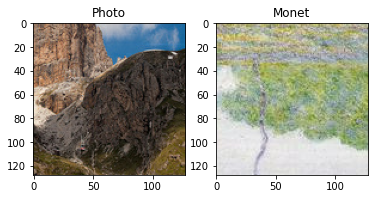

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Diff Augmentation

In [13]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

def aug_fn(image):
        return DiffAugment(image,"translation,cutout")

In [14]:
both_images = tf.concat([example_monet, example_photo], axis=0)       
aug_images = aug_fn(both_images)
aug_monet, aug_photo = tf.split(aug_images, num_or_size_splits=2, axis=0)

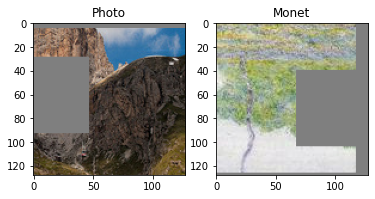

In [15]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(aug_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(aug_monet[0] * 0.5 + 0.5)

## ResNet Generator

In [16]:
def Downsample(X, filter_count, kernel_size, padding, stride, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X = tf.keras.layers.ZeroPadding2D((padding,padding))(X)
    X = tf.keras.layers.Conv2D(filter_count, (kernel_size,kernel_size), padding='valid', strides=(stride,stride), 
                                      kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.LeakyReLU()(X)
    
    return X

In [17]:
def Upsample(X, filter_count, kernel_size, stride, activation='relu', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X = tf.keras.layers.Conv2DTranspose(filter_count, (kernel_size,kernel_size), padding='same', strides=(stride,stride), 
                                        kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
        
    X = tf.keras.layers.Activation(activation)(X)
    
    return X

In [18]:
def ResidualBlock(X):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_shortcut = X
    
    # Layer 1   
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Layer 2  
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [19]:
def ResNetGenerator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))
    
    skips = []
    
    X = Downsample(X_input, 64, 7, 3, 1, apply_norm=False)
    skips.append(X)
    
    X = Downsample(X, 128, 3, 1, 2)
    skips.append(X)
    
    X = Downsample(X, 256, 3, 1, 2)
    
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    
    skips = list(reversed(skips))
        
    X = Upsample(X, 128, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[0]])
    
    X = Upsample(X, 64, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[1]])
    
    X = Upsample(X, 3, 7, 1, activation='tanh', apply_norm=False)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

In [20]:
generator = ResNetGenerator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## PatchGAN Discriminator

In [21]:
def Discriminator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))

    X = Downsample(X_input, 64, 4, 1, 2, apply_norm=False)
    X = Downsample(X, 128, 4, 1, 2)
    X = Downsample(X, 256, 4, 1, 2)
    X = Downsample(X, 512, 4, 1, 1)
    
    X = tf.keras.layers.ZeroPadding2D()(X)
    X = tf.keras.layers.Conv2D(1, (4,4), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)   
    X = tf.keras.layers.Activation('sigmoid')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

In [22]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      3072      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_22 (I (None, 64, 64, 128)       256 

In [23]:
with strategy.scope():
    monet_generator = ResNetGenerator(height=None, width=None) # transforms photos to Monet-esque paintings
    photo_generator = ResNetGenerator(height=None, width=None) # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator(height=None, width=None) # differentiates real photos and generated photos

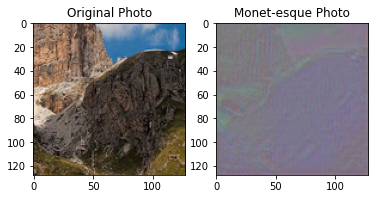

In [24]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Training

In [25]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Diff Augmentation Start
            both_monet = tf.concat([real_monet, fake_monet], axis=0)      
            both_photo = tf.concat([real_photo, fake_photo], axis=0)            
            
            aug_monet = aug_fn(both_monet)
            aug_photo = aug_fn(both_photo)
            
            aug_real_monet, aug_fake_monet = tf.split(aug_monet, num_or_size_splits=2, axis=0)
            aug_real_photo, aug_fake_photo = tf.split(aug_photo, num_or_size_splits=2, axis=0)
            # Diff Augmentation End
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(aug_real_monet, training=True)
            disc_real_photo = self.p_disc(aug_real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True)
            disc_fake_photo = self.p_disc(aug_fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [26]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [27]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [28]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [29]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [30]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

In [31]:
with strategy.scope():
    
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

In [32]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [33]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), 
                        epochs=EPOCHS, 
                        steps_per_epoch=max(n_monet_samples, n_photo_samples)//BATCH_SIZE).history

Epoch 1/100
439/439 [==============================] - 253s 180ms/step - monet_gen_loss: 2.9528 - photo_gen_loss: 3.0381 - monet_disc_loss: 0.6706 - photo_disc_loss: 0.6566
Epoch 2/100
439/439 [==============================] - 79s 180ms/step - monet_gen_loss: 2.1945 - photo_gen_loss: 2.2824 - monet_disc_loss: 0.6366 - photo_disc_loss: 0.6335
Epoch 3/100
439/439 [==============================] - 79s 180ms/step - monet_gen_loss: 2.0985 - photo_gen_loss: 2.1685 - monet_disc_loss: 0.6396 - photo_disc_loss: 0.6257
Epoch 4/100
439/439 [==============================] - 79s 180ms/step - monet_gen_loss: 2.0495 - photo_gen_loss: 2.0968 - monet_disc_loss: 0.6287 - photo_disc_loss: 0.6211
Epoch 5/100
439/439 [==============================] - 79s 180ms/step - monet_gen_loss: 1.9813 - photo_gen_loss: 2.0616 - monet_disc_loss: 0.6379 - photo_disc_loss: 0.6215
Epoch 6/100
439/439 [==============================] - 79s 181ms/step - monet_gen_loss: 1.9310 - photo_gen_loss: 2.0522 - monet_disc_loss: 

In [34]:
loss_results_df = pd.DataFrame(history)
loss_results_df = loss_results_df.applymap(np.mean)

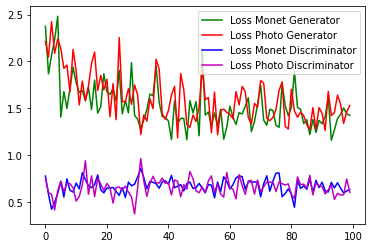

In [35]:
plt.plot(loss_results_df.index, loss_results_df['monet_gen_loss'], color='g', label='Loss Monet Generator')
plt.plot(loss_results_df.index, loss_results_df['photo_gen_loss'], color='r', label='Loss Photo Generator')
plt.plot(loss_results_df.index, loss_results_df['monet_disc_loss'], color='b', label='Loss Monet Discriminator')
plt.plot(loss_results_df.index, loss_results_df['photo_disc_loss'], color='m', label='Loss Photo Discriminator')
plt.legend(loc='best')
plt.show()

2022-06-01 13:11:34.452524: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 413400, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654089094.445734824","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 413400, Output num: 0","grpc_status":3}


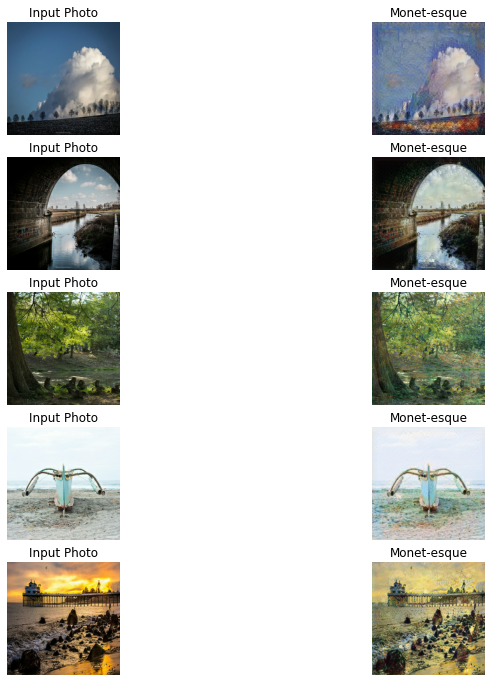

In [36]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds_test.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Prediction and Submission

In [37]:
import PIL
! mkdir ../images

In [38]:
i = 1
for img in photo_ds_test:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-06-01 14:06:41.128000: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 7120623, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654092401.127897590","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 7120623, Output num: 0","grpc_status":3}


In [39]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'